#### An examination of how the number of classes influences prediction accuracy in machine learning.

In the example below, hypothetical datasets are generated with varying numbers of classes ranging from 2 to 100. Subsequently, these datasets are attempted to be classified using different machine learning algorithms. In this context, the aim is to identify potential effects of the number of classes on the overall performance.
Classification methods:

 - Decision Tree Classifier
 - Bernoulli Naive Bayes 
 - K-Neighbors Classifier
 - LogisticR egression
 - Random Forest Classifier
 - MLP Classifier
 - Randomly (obtained by randomly assigning the results)
 


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score



In [5]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [6]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add
path="./csvs"
csv_list=find_the_way(path,".csv")
csv_list

[]

In [7]:
ml_list={"DT":DecisionTreeClassifier(),
         #"XGB": XGBClassifier(),
         "NB": BernoulliNB(), 
         "kNN": KNeighborsClassifier(),
         "LR": LogisticRegression(),
         "RF":RandomForestClassifier(),
          "MLP":MLPClassifier(),
        "RND":"RND"}




In [8]:
def target_name(name):
    df = pd.read_csv(name)
    target_names=sorted(list(df[df.columns[-1]].unique()))
    return target_names

In [9]:
folder("results")

## Calculation of evaluations

In [10]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=np.nan
    report = sklearn.metrics.classification_report(y_test, predict,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import random


def create_dataset(n):
    X, y = make_classification(
        n_samples=1000,  # row number
        n_features=10, # feature numbers
        n_informative=6, # The number of informative features
        n_redundant = 2, # The number of redundant features
        n_repeated = 2, # The number of duplicated features
        n_classes = n, # The number of classes 
        n_clusters_per_class=1,#The number of clusters per class
        random_state = 42 # random seed 
        
        
    )
    return X,y

In [12]:
def ML_CV(X,y,classnumber):
    fold=5
    dname=str(classnumber)
    repetition=5
    sw=np.nan
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        cm = pd.DataFrame()
        for i in range(repetition):
      
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(i*100))  
            cv=0

            for train_index, test_index in kfold.split(X):


                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

      


                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                
                second=time.time()
                if clf!="RND":
                    clf.fit(X_train, y_train)
                    train_time.append(float((time.time()-second)) )
                    second=time.time()
                    predict =clf.predict(X_test)
                    test_time.append(float((time.time()-second)) )
                else:
                    
                    train_time.append(float((time.time()-second)) )
                    second=time.time()
                    predict = [random.randint(0, classnumber) for _ in range(len(y)//5)]
                    test_time.append(float((time.time()-second)) )
                
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

                
                
                
                
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)
                
                
                
                
                
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        del results["SW"]
        del results["ROC"]
        
        print (tabulate(results, headers=list(results.columns)))



In [14]:
basla=time.time()            
    
for i  in range (2,65):
    X,y=create_dataset(i)    
    temp = str(i)
    temp=temp.zfill(3)
    output_csv=f"./results/{temp}_ML.csv"
    ML_CV(X,y,i)
    break

#print(time.time() -basla   )

      Dataset    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    tra-T    test-T
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -------  --------
 0          2    1     0  DT    0.89     0.889   0.889  0.889  0.889  0.778    0.013     0.001
 1          2    2     0  DT    0.925    0.924   0.923  0.924  0.923  0.846    0.016     0
 2          2    3     0  DT    0.915    0.915   0.915  0.915  0.915  0.83     0.016     0
 3          2    4     0  DT    0.9      0.9     0.9    0.9    0.9    0.8      0.011     0
 4          2    5     0  DT    0.89     0.89    0.891  0.89   0.89   0.78     0         0
 5          2    1     1  DT    0.885    0.885   0.884  0.885  0.885  0.769    0         0.016
 6          2    2     1  DT    0.91     0.91    0.911  0.91   0.91   0.82     0.016     0
 7          2    3     1  DT    0.87     0.873   0.874  0.873  0.87   0.741    0.006     0
 8          2    4     1  DT    0.91     0.911   0.912  0.911  0.91   0.82

      Dataset    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    tra-T    test-T
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -------  --------
 0          2    1     0  RF    0.96     0.959   0.961  0.959  0.96   0.919    0.388     0.012
 1          2    2     0  RF    0.935    0.941   0.932  0.941  0.934  0.869    0.441     0.018
 2          2    3     0  RF    0.95     0.95    0.95   0.95   0.95   0.9      0.403     0.013
 3          2    4     0  RF    0.91     0.91    0.912  0.91   0.91   0.82     0.366     0.013
 4          2    5     0  RF    0.95     0.95    0.95   0.95   0.95   0.9      0.44      0
 5          2    1     1  RF    0.93     0.928   0.931  0.928  0.929  0.859    0.4       0.014
 6          2    2     1  RF    0.95     0.95    0.95   0.95   0.95   0.9      0.386     0.013
 7          2    3     1  RF    0.935    0.938   0.938  0.938  0.935  0.87     0.41      0.029
 8          2    4     1  RF    0.925    0.926   0.928

In [15]:
name_list=find_the_way('./results/','.csv')
name_list

['./results/002_DT.csv',
 './results/002_kNN.csv',
 './results/002_LR.csv',
 './results/002_MLP.csv',
 './results/002_NB.csv',
 './results/002_RF.csv',
 './results/002_RND.csv',
 './results/002_XGB.csv',
 './results/003_DT.csv',
 './results/003_kNN.csv',
 './results/003_LR.csv',
 './results/003_MLP.csv',
 './results/003_NB.csv',
 './results/003_RF.csv',
 './results/003_RND.csv',
 './results/003_XGB.csv',
 './results/004_DT.csv',
 './results/004_kNN.csv',
 './results/004_LR.csv',
 './results/004_MLP.csv',
 './results/004_NB.csv',
 './results/004_RF.csv',
 './results/004_RND.csv',
 './results/004_XGB.csv',
 './results/005_DT.csv',
 './results/005_kNN.csv',
 './results/005_LR.csv',
 './results/005_MLP.csv',
 './results/005_NB.csv',
 './results/005_RF.csv',
 './results/005_RND.csv',
 './results/006_DT.csv',
 './results/006_kNN.csv',
 './results/006_LR.csv',
 './results/006_MLP.csv',
 './results/006_NB.csv',
 './results/006_RF.csv',
 './results/006_RND.csv',
 './results/007_DT.csv',
 './res

In [16]:
folder("outputs")
for j in ml_list:
    name_list=find_the_way('./results/',f'{j}')
    #print(name_list)
    flag=1
    for i in name_list:
        df = pd.read_csv(i) 
        temp=pd.DataFrame(df.mean())
        col=i[10:-7]
        #print(col)
        if flag:
            std=temp
            flag=0
        else:
            std[col]=temp.values
    aalto=std.T
    aalto.to_csv(f"./outputs/{j}.csv",index=False)

In [17]:
name_list=find_the_way('./outputs/',f'.csv')

name_list

['./outputs/DT.csv',
 './outputs/kNN.csv',
 './outputs/LR.csv',
 './outputs/MLP.csv',
 './outputs/NB.csv',
 './outputs/RF.csv',
 './outputs/RND.csv']

In [18]:
names={"DT":"Decision Tree",
         "NB": "Bernoulli Naive Bayes", 
         "kNN": "K-Neighbors",
         "LR": "Logistic Regression",
         "RF": "Random Forest",
          "MLP":"Multilayer perceptron",
        "RND":"Randomly assigned labels"}

 


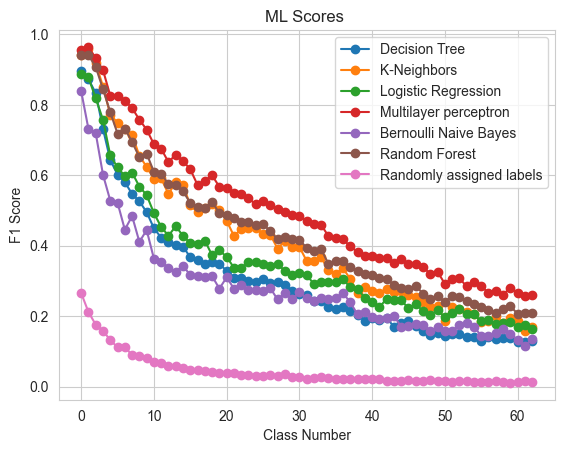

In [19]:
graph_name="F1.pdf"
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
for i in  name_list:
    
    data = pd.read_csv(i)
    my_xticks=range(len(data))
    plt.plot(my_xticks,data["F1"], linestyle='-', marker='o',label= names[i[10:-4]])
    
plt.title("ML Scores ")
plt.legend(numpoints=1)
plt.ylabel("F1 Score")
plt.xlabel("Class Number")
#plt.xticks(rotation=90) 

plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)

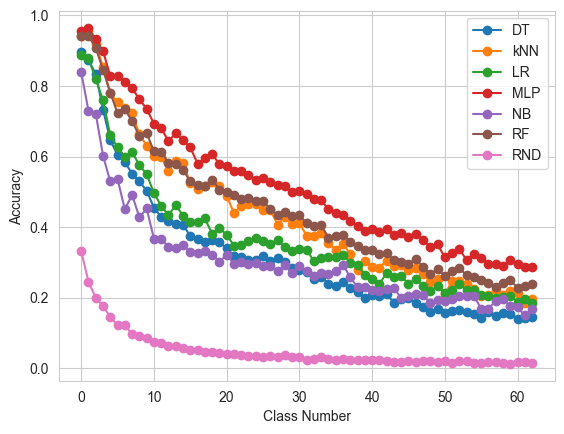

In [20]:
graph_name="ACC1.pdf"
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
for i in  name_list:
    
    data = pd.read_csv(i)
    my_xticks=range(len(data))
    plt.plot(my_xticks,data['Acc'], linestyle='-', marker='o',label= i[10:-4])
    
#plt.title("ML Scores ")
plt.legend(numpoints=1)
plt.ylabel("Accuracy")
plt.xlabel("Class Number")
#plt.xticks(rotation=90) 

plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)

In [21]:
#!shutdown /s /t 1000